In [1]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/kaggle/working/6D_pose"   #Modify here for kaggle
branch = "pose_Dense_Fusion"

# Clone if missing
if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url} to {repo_dir}")
else:
    %cd {repo_dir}
    !git fetch origin
    !git checkout {branch}
    !git reset --hard origin/{branch}
    # %cd ..
    print(f"Updated {repo_url} to {repo_dir}")

# Add repository to Python path
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)


Cloning into '6D_pose'...
remote: Enumerating objects: 993, done.
remote: Counting objects: 100% (319/319), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 993 (delta 176), reused 233 (delta 120), pack-reused 674 (from 1)
Receiving objects: 100% (993/993), 18.00 MiB | 36.71 MiB/s, done.
Resolving deltas: 100% (558/558), done.
Cloned https://github.com/fraco03/6D_pose.git to /kaggle/working/6D_pose


In [3]:
sys.path.insert(0,"/kaggle/working/6D_pose")

In [ ]:
%cd ..
!gdown --fuzzy https://drive.google.com/file/d/1zNthSyiBdPUfn7BmUKPbKoGgQdG1vGnS/view?usp=drive_link -O Linemod_preprocessed.zip
!unzip Linemod_preprocessed.zip
%cd 6D_pose

In [ ]:
from google.colab import drive
from utils.load_data import mount_drive

# Mounting part
mount_drive()

In [4]:
%mv Linemod_preprocessed working/

mv: cannot stat 'Linemod_preprocessed': No such file or directory


In [4]:
# dataset_root = "/content/drive/MyDrive/Linemod_preprocessed" #Modify here for kaggle
# dataset_root = "../../Linemod_preprocessed_small"
# dataset_root = "/content/Linemod_preprocessed"
# dataset_root = "/kaggle/working/Linemod_preprocessed"
dataset_root = "/kaggle/input/line-mode/Linemod_preprocessed"

print("\n✅ Setup complete!")
print(f"📁 Dataset path: {dataset_root}")



✅ Setup complete!
📁 Dataset path: /kaggle/input/line-mode/Linemod_preprocessed


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%mv Linemod_preprocessed ./working

In [5]:
!pip install plyfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.4 MB/s eta 0:00:00


In [6]:
import sys

sys.path.append('../..')

In [7]:
from src.dense_fusion.dataset import DenseFusionLineModDataset

train_dataset = DenseFusionLineModDataset(
    root_dir=dataset_root,
    split="train"
)

test_dataset = DenseFusionLineModDataset(
    root_dir=dataset_root,
    split="test"
)


✅ Loaded DenseFusionLineModDataset
   Split: train (Ratio: 0.8)
   Num Points: 1024
   Total samples: 12634
   RGB Resize Shape: (128, 128)
✅ Loaded DenseFusionLineModDataset
   Split: test (Ratio: 0.8)
   Num Points: 1024
   Total samples: 3166
   RGB Resize Shape: (128, 128)


In [8]:
import torch
sample = train_dataset[0]

print(f"Sample keys: {sample.keys()}")
for key, value in sample.items():
    if isinstance(value, torch.Tensor):
        print(f"  {key}: Tensor of shape {value.shape} and dtype {value.dtype}")
    else:
        print(f"  {key}: {type(value)} with value {value}")

Sample keys: dict_keys(['points', 'rgb', 'choose', 'centroid', 'rotation', 't_residual', 'gt_translation', 'object_id', 'class_idx', 'img_id', 'cam_K', 'img_path'])
  points: Tensor of shape torch.Size([3, 1024]) and dtype torch.float32
  rgb: Tensor of shape torch.Size([3, 128, 128]) and dtype torch.float32
  choose: Tensor of shape torch.Size([1024]) and dtype torch.int64
  centroid: Tensor of shape torch.Size([3]) and dtype torch.float32
  rotation: Tensor of shape torch.Size([4]) and dtype torch.float32
  t_residual: Tensor of shape torch.Size([3]) and dtype torch.float32
  gt_translation: Tensor of shape torch.Size([3]) and dtype torch.float32
  object_id: <class 'int'> with value 1
  class_idx: <class 'str'> with value ape
  img_id: <class 'int'> with value 987
  cam_K: Tensor of shape torch.Size([3, 3]) and dtype torch.float32
  img_path: <class 'str'> with value /kaggle/input/line-mode/Linemod_preprocessed/data/01/rgb/0987.png


In [9]:
import torch

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
from utils.linemod_config import get_linemod_config
import numpy as np
import torch


linemod_config = get_linemod_config(dataset_root)

all_model_points = []
NUM_POINTS = 1000  # Number of points to sample from each model
VALID_OBJ_IDS = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15] 
for obj_id in VALID_OBJ_IDS:
    model_points = linemod_config.get_model_3d(obj_id, unit='m')  # (N, 3)
    if model_points.shape[0] >= NUM_POINTS:
        choice = np.random.choice(model_points.shape[0], NUM_POINTS, replace=False)
    else:
        choice = np.random.choice(model_points.shape[0], NUM_POINTS, replace=True)
    model_points = model_points[choice, :]
    all_model_points.append(torch.tensor(model_points, dtype=torch.float32))
all_model_points = torch.stack(all_model_points, dim=0)  # (Num_Classes, NUM_POINTS, 3)
all_model_points = all_model_points.to(device)

max_obj_id = max(VALID_OBJ_IDS)

# Create a lookup table: obj_id -> index
obj_id_to_idx = torch.full((max_obj_id + 1,), -1, dtype=torch.long, device=device)
for idx, obj_id in enumerate(VALID_OBJ_IDS):
    obj_id_to_idx[obj_id] = idx


In [12]:
all_model_points.shape

torch.Size([13, 1000, 3])

In [14]:
from src.dense_fusion.loss import MultiObjectPointMatchingLoss
import torch.nn as nn
from src.dense_fusion.model import FusionPoseModel
import torch.nn as nn
from src.dense_fusion.model import PointNetPoseModel
from torch.optim import Adam, AdamW

model = FusionPoseModel(num_points=1024).to(device)

if torch.cuda.device_count() > 1:
    print(f"🔥 Using {torch.cuda.device_count()} GPU!")
    model = nn.DataParallel(model)

model = model.to(device)

# Loss function and optimizer
criterion = MultiObjectPointMatchingLoss(all_model_points)
optimizer = AdamW(
    model.parameters(), 
    lr=0.001, 
    betas=(0.9, 0.999), 
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=100,      # Imposta il numero delle tue epoche totali qui!
    eta_min=1e-5
)

🔥 Using 2 GPU!


In [15]:
def set_bn_momentum_default(curr_epoch, total_epochs, model):
    """
    Decade il momentum della Batch Norm da 0.1 a 0.01 seguendo una curva a step o coseno.
    In PyTorch il default momentum è 0.1.
    """
    # Formula originale PointNet: decade del 50% ogni tot step
    # Qui usiamo una versione coseno più moderna e fluida
    
    # Calcola il momentum target: parte da 0.1 e scende a 0.01
    start_mom = 0.1
    end_mom = 0.01
    
    # Interpolazione semplice basata sull'epoca
    momentum = end_mom + (start_mom - end_mom) * (1 - (curr_epoch / total_epochs))
    
    # Applica a tutti i layer di Batch Norm nel modello
    for m in model.modules():
        if isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
            m.momentum = momentum

In [16]:
from torch.utils.data import DataLoader

batch_size = 128  #double GPU

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [17]:
from tqdm import tqdm
import os
import torch
from datetime import datetime

# ==========================================
# 0. SETUP AND CONFIGURATION
# ==========================================
num_epochs = 100  # PointNet converges relatively fast
best_test_loss = float('inf')
batch_size = 32  # Adjust based on your GPU VRAM

# Setup checkpoint directory
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint_dir = f'/kaggle/working/DENSE_FUSION{timestamp}'
# checkpoint_dir = f'./DENSE_FUSION{timestamp}'
os.makedirs(checkpoint_dir, exist_ok=True)

# Trackers for plotting
train_losses = []
test_losses = []

print(f"🚀 Starting Dense Fusion Training on {device}")
print(f"📁 Checkpoints will be saved to: {checkpoint_dir}")
print(f"🗺️  Object ID Mapping created for {len(obj_id_to_idx)} objects.")

# ==========================================
# 1. TRAINING LOOP
# ==========================================
for epoch in range(num_epochs):
    set_bn_momentum_default(epoch, num_epochs, model)
    
    model.train()
    epoch_loss = 0.0

    # Initialize progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training")
    
    for batch in train_pbar:
        # Move data to GPU
        # PointNet input: (Batch, 3, Num_Points)
        points = batch['points'].to(device)  

        # DenseFusion addiional input: images
        images = batch['rgb'].to(device)
        
        # Auxiliary data for reconstruction and loss
        centroids = batch['centroid'].to(device)       # (B, 3)
        gt_rotations = batch['rotation'].to(device)    # (B, 4)
        gt_t_absolute = batch['gt_translation'].to(device) # (B, 3) - Absolute target
        
        # Handle Object IDs for Loss Indexing
        raw_obj_ids = batch['object_id'].tolist()
        # Map raw IDs (e.g., 15) to buffer indices (e.g., 12)
        target_indices = torch.tensor(
            [obj_id_to_idx[oid] for oid in raw_obj_ids], 
            dtype=torch.long, device=device
        )

        # --- FORWARD PASS ---
        optimizer.zero_grad()
        
        # The network predicts: 
        # 1. Quaternion (pred_q)
        # 2. Residual Translation relative to centroid (pred_t_res)
        pred_q, pred_t_res = model(points, images)

        # --- RECONSTRUCTION ---
        # Reconstruct absolute translation for the ADD Loss
        # Absolute_Pos = Centroid + Residual
        pred_t_abs = centroids + pred_t_res

        # --- LOSS CALCULATION ---
        # Using MultiObjectPointMatchingLoss (ADD metric)
        loss = criterion(
            pred_q=pred_q, 
            pred_t=pred_t_abs,   # Pass the reconstructed absolute translation
            gt_q=gt_rotations, 
            gt_t=gt_t_absolute, 
            class_indices=target_indices
        )
        
        loss.backward()
        optimizer.step()

        # Update stats
        epoch_loss += loss.item()
        train_pbar.set_postfix({'ADD Loss (m)': f"{loss.item():.4f}"})

    # Calculate average training loss
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    scheduler.step()

    # ==========================================
    # 2. VALIDATION LOOP
    # ==========================================
    model.eval()
    test_loss = 0.0
    val_pbar = tqdm(test_loader, desc="Validating")
    
    with torch.no_grad():
        for batch in val_pbar:
            # Move data to GPU
            points = batch['points'].to(device)
            images = batch['rgb'].to(device) # Ensure this is extracted
            centroids = batch['centroid'].to(device)
            gt_rotations = batch['rotation'].to(device)
            gt_t_absolute = batch['gt_translation'].to(device)
            
            # Map IDs
            raw_obj_ids = batch['object_id'].tolist()
            target_indices = torch.tensor(
                [obj_id_to_idx[oid] for oid in raw_obj_ids], 
                dtype=torch.long, device=device
            )

            # --- FIX IS HERE ---
            # Forward (pass BOTH points and images)
            pred_q, pred_t_res = model(points, images)
            # -------------------

            # Reconstruction
            pred_t_abs = centroids + pred_t_res

            # Loss
            loss = criterion(
                pred_q=pred_q, 
                pred_t=pred_t_abs, 
                gt_q=gt_rotations, 
                gt_t=gt_t_absolute, 
                class_indices=target_indices
            )
            
            test_loss += loss.item()
            val_pbar.set_postfix({'Val Loss': f"{loss.item():.4f}"})

    # Calculate average validation loss
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f"📊 Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} m | Val Loss: {avg_test_loss:.4f} m")

    # ==========================================
    # 3. CHECKPOINT SAVING
    # ==========================================
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
        
        # Handle DataParallel state_dict if necessary
        model_state = model.module.state_dict() if isinstance(model, torch.nn.DataParallel) else model.state_dict()
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_test_loss,
            'config': { 
                'num_points': 1024, # Useful for inference
                'obj_map': obj_id_to_idx
            }
        }, checkpoint_path)
        print(f"✅ New Record! Model saved with Loss: {best_test_loss:.4f} m")
    else:
        print(f"⏳ No improvement (Best: {best_test_loss:.4f} m)")
    
    print("-" * 60)

🚀 Starting Dense Fusion Training on cuda
📁 Checkpoints will be saved to: /kaggle/working/DENSE_FUSION20251223_192627
🗺️  Object ID Mapping created for 16 objects.


Validating: 100%|██████████| 25/25 [01:01<00:00,  2.48s/it, Val Loss=0.0653]


📊 Epoch [1/100] | Train Loss: 0.2243 m | Val Loss: 0.0574 m
✅ New Record! Model saved with Loss: 0.0574 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it, Val Loss=0.0637]


📊 Epoch [2/100] | Train Loss: 0.1061 m | Val Loss: 0.0598 m
⏳ No improvement (Best: 0.0574 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it, Val Loss=0.0413]


📊 Epoch [3/100] | Train Loss: 0.0649 m | Val Loss: 0.0363 m
✅ New Record! Model saved with Loss: 0.0363 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0282]


📊 Epoch [4/100] | Train Loss: 0.0378 m | Val Loss: 0.0325 m
✅ New Record! Model saved with Loss: 0.0325 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it, Val Loss=0.0300]


📊 Epoch [5/100] | Train Loss: 0.0309 m | Val Loss: 0.0295 m
✅ New Record! Model saved with Loss: 0.0295 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.36s/it, Val Loss=0.0287]


📊 Epoch [6/100] | Train Loss: 0.0264 m | Val Loss: 0.0263 m
✅ New Record! Model saved with Loss: 0.0263 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.43s/it, Val Loss=0.0301]


📊 Epoch [7/100] | Train Loss: 0.0255 m | Val Loss: 0.0219 m
✅ New Record! Model saved with Loss: 0.0219 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.36s/it, Val Loss=0.0199]


📊 Epoch [8/100] | Train Loss: 0.0264 m | Val Loss: 0.0243 m
⏳ No improvement (Best: 0.0219 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, Val Loss=0.0267]


📊 Epoch [9/100] | Train Loss: 0.0249 m | Val Loss: 0.0275 m
⏳ No improvement (Best: 0.0219 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.36s/it, Val Loss=0.0212]


📊 Epoch [10/100] | Train Loss: 0.0241 m | Val Loss: 0.0245 m
⏳ No improvement (Best: 0.0219 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0284]


📊 Epoch [11/100] | Train Loss: 0.0232 m | Val Loss: 0.0279 m
⏳ No improvement (Best: 0.0219 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.36s/it, Val Loss=0.0205]


📊 Epoch [12/100] | Train Loss: 0.0240 m | Val Loss: 0.0196 m
✅ New Record! Model saved with Loss: 0.0196 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it, Val Loss=0.0228]


📊 Epoch [13/100] | Train Loss: 0.0232 m | Val Loss: 0.0209 m
⏳ No improvement (Best: 0.0196 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it, Val Loss=0.0295]


📊 Epoch [14/100] | Train Loss: 0.0228 m | Val Loss: 0.0247 m
⏳ No improvement (Best: 0.0196 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it, Val Loss=0.0307]


📊 Epoch [15/100] | Train Loss: 0.0231 m | Val Loss: 0.0267 m
⏳ No improvement (Best: 0.0196 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, Val Loss=0.0296]


📊 Epoch [16/100] | Train Loss: 0.0255 m | Val Loss: 0.0248 m
⏳ No improvement (Best: 0.0196 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0259]


📊 Epoch [17/100] | Train Loss: 0.0248 m | Val Loss: 0.0225 m
⏳ No improvement (Best: 0.0196 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.40s/it, Val Loss=0.0222]


📊 Epoch [18/100] | Train Loss: 0.0226 m | Val Loss: 0.0204 m
⏳ No improvement (Best: 0.0196 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.41s/it, Val Loss=0.0237]


📊 Epoch [19/100] | Train Loss: 0.0227 m | Val Loss: 0.0269 m
⏳ No improvement (Best: 0.0196 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0184]


📊 Epoch [20/100] | Train Loss: 0.0212 m | Val Loss: 0.0207 m
⏳ No improvement (Best: 0.0196 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0208]


📊 Epoch [21/100] | Train Loss: 0.0201 m | Val Loss: 0.0194 m
✅ New Record! Model saved with Loss: 0.0194 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0254]


📊 Epoch [22/100] | Train Loss: 0.0202 m | Val Loss: 0.0199 m
⏳ No improvement (Best: 0.0194 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it, Val Loss=0.0184]


📊 Epoch [23/100] | Train Loss: 0.0208 m | Val Loss: 0.0195 m
⏳ No improvement (Best: 0.0194 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it, Val Loss=0.0229]


📊 Epoch [24/100] | Train Loss: 0.0194 m | Val Loss: 0.0192 m
✅ New Record! Model saved with Loss: 0.0192 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0227]


📊 Epoch [25/100] | Train Loss: 0.0187 m | Val Loss: 0.0196 m
⏳ No improvement (Best: 0.0192 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0182]


📊 Epoch [26/100] | Train Loss: 0.0193 m | Val Loss: 0.0154 m
✅ New Record! Model saved with Loss: 0.0154 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.40s/it, Val Loss=0.0198]


📊 Epoch [27/100] | Train Loss: 0.0171 m | Val Loss: 0.0158 m
⏳ No improvement (Best: 0.0154 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0199]


📊 Epoch [28/100] | Train Loss: 0.0186 m | Val Loss: 0.0151 m
✅ New Record! Model saved with Loss: 0.0151 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.40s/it, Val Loss=0.0190]


📊 Epoch [29/100] | Train Loss: 0.0171 m | Val Loss: 0.0161 m
⏳ No improvement (Best: 0.0151 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0195]


📊 Epoch [30/100] | Train Loss: 0.0173 m | Val Loss: 0.0192 m
⏳ No improvement (Best: 0.0151 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.40s/it, Val Loss=0.0167]


📊 Epoch [31/100] | Train Loss: 0.0187 m | Val Loss: 0.0147 m
✅ New Record! Model saved with Loss: 0.0147 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.43s/it, Val Loss=0.0163]


📊 Epoch [32/100] | Train Loss: 0.0160 m | Val Loss: 0.0147 m
⏳ No improvement (Best: 0.0147 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.43s/it, Val Loss=0.0154]


📊 Epoch [33/100] | Train Loss: 0.0165 m | Val Loss: 0.0134 m
✅ New Record! Model saved with Loss: 0.0134 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.40s/it, Val Loss=0.0194]


📊 Epoch [34/100] | Train Loss: 0.0158 m | Val Loss: 0.0155 m
⏳ No improvement (Best: 0.0134 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.44s/it, Val Loss=0.0197]


📊 Epoch [35/100] | Train Loss: 0.0153 m | Val Loss: 0.0179 m
⏳ No improvement (Best: 0.0134 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0147]


📊 Epoch [36/100] | Train Loss: 0.0152 m | Val Loss: 0.0138 m
⏳ No improvement (Best: 0.0134 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0176]


📊 Epoch [37/100] | Train Loss: 0.0158 m | Val Loss: 0.0147 m
⏳ No improvement (Best: 0.0134 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.40s/it, Val Loss=0.0178]


📊 Epoch [38/100] | Train Loss: 0.0157 m | Val Loss: 0.0148 m
⏳ No improvement (Best: 0.0134 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, Val Loss=0.0133]


📊 Epoch [39/100] | Train Loss: 0.0148 m | Val Loss: 0.0128 m
✅ New Record! Model saved with Loss: 0.0128 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0181]


📊 Epoch [40/100] | Train Loss: 0.0151 m | Val Loss: 0.0142 m
⏳ No improvement (Best: 0.0128 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0150]


📊 Epoch [41/100] | Train Loss: 0.0148 m | Val Loss: 0.0140 m
⏳ No improvement (Best: 0.0128 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0138]


📊 Epoch [42/100] | Train Loss: 0.0151 m | Val Loss: 0.0128 m
⏳ No improvement (Best: 0.0128 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0125]


📊 Epoch [43/100] | Train Loss: 0.0141 m | Val Loss: 0.0118 m
✅ New Record! Model saved with Loss: 0.0118 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0185]


📊 Epoch [44/100] | Train Loss: 0.0141 m | Val Loss: 0.0150 m
⏳ No improvement (Best: 0.0118 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, Val Loss=0.0124]


📊 Epoch [45/100] | Train Loss: 0.0144 m | Val Loss: 0.0115 m
✅ New Record! Model saved with Loss: 0.0115 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.41s/it, Val Loss=0.0139]


📊 Epoch [46/100] | Train Loss: 0.0142 m | Val Loss: 0.0131 m
⏳ No improvement (Best: 0.0115 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0141]


📊 Epoch [47/100] | Train Loss: 0.0138 m | Val Loss: 0.0123 m
⏳ No improvement (Best: 0.0115 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it, Val Loss=0.0129]


📊 Epoch [48/100] | Train Loss: 0.0134 m | Val Loss: 0.0109 m
✅ New Record! Model saved with Loss: 0.0109 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it, Val Loss=0.0142]


📊 Epoch [49/100] | Train Loss: 0.0128 m | Val Loss: 0.0121 m
⏳ No improvement (Best: 0.0109 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it, Val Loss=0.0142]


📊 Epoch [50/100] | Train Loss: 0.0132 m | Val Loss: 0.0120 m
⏳ No improvement (Best: 0.0109 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it, Val Loss=0.0123]


📊 Epoch [51/100] | Train Loss: 0.0128 m | Val Loss: 0.0109 m
⏳ No improvement (Best: 0.0109 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it, Val Loss=0.0119]


📊 Epoch [52/100] | Train Loss: 0.0120 m | Val Loss: 0.0094 m
✅ New Record! Model saved with Loss: 0.0094 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0124]


📊 Epoch [53/100] | Train Loss: 0.0117 m | Val Loss: 0.0106 m
⏳ No improvement (Best: 0.0094 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it, Val Loss=0.0131]


📊 Epoch [54/100] | Train Loss: 0.0122 m | Val Loss: 0.0107 m
⏳ No improvement (Best: 0.0094 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0138]


📊 Epoch [55/100] | Train Loss: 0.0124 m | Val Loss: 0.0115 m
⏳ No improvement (Best: 0.0094 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0170]


📊 Epoch [56/100] | Train Loss: 0.0120 m | Val Loss: 0.0118 m
⏳ No improvement (Best: 0.0094 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, Val Loss=0.0131]


📊 Epoch [57/100] | Train Loss: 0.0119 m | Val Loss: 0.0109 m
⏳ No improvement (Best: 0.0094 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.40s/it, Val Loss=0.0106]


📊 Epoch [58/100] | Train Loss: 0.0116 m | Val Loss: 0.0092 m
✅ New Record! Model saved with Loss: 0.0092 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0110]


📊 Epoch [59/100] | Train Loss: 0.0112 m | Val Loss: 0.0095 m
⏳ No improvement (Best: 0.0092 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0095]


📊 Epoch [60/100] | Train Loss: 0.0112 m | Val Loss: 0.0091 m
✅ New Record! Model saved with Loss: 0.0091 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.41s/it, Val Loss=0.0102]


📊 Epoch [61/100] | Train Loss: 0.0108 m | Val Loss: 0.0089 m
✅ New Record! Model saved with Loss: 0.0089 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.43s/it, Val Loss=0.0095]


📊 Epoch [62/100] | Train Loss: 0.0107 m | Val Loss: 0.0086 m
✅ New Record! Model saved with Loss: 0.0086 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it, Val Loss=0.0127]


📊 Epoch [63/100] | Train Loss: 0.0106 m | Val Loss: 0.0103 m
⏳ No improvement (Best: 0.0086 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.41s/it, Val Loss=0.0089]


📊 Epoch [64/100] | Train Loss: 0.0105 m | Val Loss: 0.0084 m
✅ New Record! Model saved with Loss: 0.0084 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0139]


📊 Epoch [65/100] | Train Loss: 0.0104 m | Val Loss: 0.0095 m
⏳ No improvement (Best: 0.0084 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.40s/it, Val Loss=0.0111]


📊 Epoch [66/100] | Train Loss: 0.0111 m | Val Loss: 0.0087 m
⏳ No improvement (Best: 0.0084 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.41s/it, Val Loss=0.0103]


📊 Epoch [67/100] | Train Loss: 0.0103 m | Val Loss: 0.0086 m
⏳ No improvement (Best: 0.0084 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.41s/it, Val Loss=0.0120]


📊 Epoch [68/100] | Train Loss: 0.0105 m | Val Loss: 0.0115 m
⏳ No improvement (Best: 0.0084 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:36<00:00,  1.44s/it, Val Loss=0.0105]


📊 Epoch [69/100] | Train Loss: 0.0110 m | Val Loss: 0.0090 m
⏳ No improvement (Best: 0.0084 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0127]


📊 Epoch [70/100] | Train Loss: 0.0116 m | Val Loss: 0.0102 m
⏳ No improvement (Best: 0.0084 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0102]


📊 Epoch [71/100] | Train Loss: 0.0113 m | Val Loss: 0.0089 m
⏳ No improvement (Best: 0.0084 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0110]


📊 Epoch [72/100] | Train Loss: 0.0105 m | Val Loss: 0.0092 m
⏳ No improvement (Best: 0.0084 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it, Val Loss=0.0102]


📊 Epoch [73/100] | Train Loss: 0.0107 m | Val Loss: 0.0089 m
⏳ No improvement (Best: 0.0084 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0099]


📊 Epoch [74/100] | Train Loss: 0.0104 m | Val Loss: 0.0089 m
⏳ No improvement (Best: 0.0084 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0089]


📊 Epoch [75/100] | Train Loss: 0.0104 m | Val Loss: 0.0082 m
✅ New Record! Model saved with Loss: 0.0082 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0087]


📊 Epoch [76/100] | Train Loss: 0.0100 m | Val Loss: 0.0080 m
✅ New Record! Model saved with Loss: 0.0080 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.40s/it, Val Loss=0.0081]


📊 Epoch [77/100] | Train Loss: 0.0101 m | Val Loss: 0.0082 m
⏳ No improvement (Best: 0.0080 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it, Val Loss=0.0090]


📊 Epoch [78/100] | Train Loss: 0.0099 m | Val Loss: 0.0078 m
✅ New Record! Model saved with Loss: 0.0078 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it, Val Loss=0.0105]


📊 Epoch [79/100] | Train Loss: 0.0101 m | Val Loss: 0.0087 m
⏳ No improvement (Best: 0.0078 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:35<00:00,  1.41s/it, Val Loss=0.0081]


📊 Epoch [80/100] | Train Loss: 0.0099 m | Val Loss: 0.0078 m
✅ New Record! Model saved with Loss: 0.0078 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.36s/it, Val Loss=0.0089]


📊 Epoch [81/100] | Train Loss: 0.0097 m | Val Loss: 0.0077 m
✅ New Record! Model saved with Loss: 0.0077 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, Val Loss=0.0082]


📊 Epoch [82/100] | Train Loss: 0.0098 m | Val Loss: 0.0075 m
✅ New Record! Model saved with Loss: 0.0075 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.40s/it, Val Loss=0.0086]


📊 Epoch [83/100] | Train Loss: 0.0096 m | Val Loss: 0.0077 m
⏳ No improvement (Best: 0.0075 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, Val Loss=0.0082]


📊 Epoch [84/100] | Train Loss: 0.0095 m | Val Loss: 0.0073 m
✅ New Record! Model saved with Loss: 0.0073 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0090]


📊 Epoch [85/100] | Train Loss: 0.0095 m | Val Loss: 0.0076 m
⏳ No improvement (Best: 0.0073 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0088]


📊 Epoch [86/100] | Train Loss: 0.0096 m | Val Loss: 0.0078 m
⏳ No improvement (Best: 0.0073 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it, Val Loss=0.0082]


📊 Epoch [87/100] | Train Loss: 0.0095 m | Val Loss: 0.0075 m
⏳ No improvement (Best: 0.0073 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, Val Loss=0.0084]


📊 Epoch [88/100] | Train Loss: 0.0094 m | Val Loss: 0.0073 m
✅ New Record! Model saved with Loss: 0.0073 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, Val Loss=0.0081]


📊 Epoch [89/100] | Train Loss: 0.0093 m | Val Loss: 0.0074 m
⏳ No improvement (Best: 0.0073 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it, Val Loss=0.0077]


📊 Epoch [90/100] | Train Loss: 0.0093 m | Val Loss: 0.0070 m
✅ New Record! Model saved with Loss: 0.0070 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0075]


📊 Epoch [91/100] | Train Loss: 0.0091 m | Val Loss: 0.0069 m
✅ New Record! Model saved with Loss: 0.0069 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, Val Loss=0.0080]


📊 Epoch [92/100] | Train Loss: 0.0090 m | Val Loss: 0.0070 m
⏳ No improvement (Best: 0.0069 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it, Val Loss=0.0080]


📊 Epoch [93/100] | Train Loss: 0.0090 m | Val Loss: 0.0069 m
⏳ No improvement (Best: 0.0069 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:33<00:00,  1.36s/it, Val Loss=0.0081]


📊 Epoch [94/100] | Train Loss: 0.0090 m | Val Loss: 0.0070 m
⏳ No improvement (Best: 0.0069 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it, Val Loss=0.0076]


📊 Epoch [95/100] | Train Loss: 0.0090 m | Val Loss: 0.0067 m
✅ New Record! Model saved with Loss: 0.0067 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, Val Loss=0.0081]


📊 Epoch [96/100] | Train Loss: 0.0090 m | Val Loss: 0.0069 m
⏳ No improvement (Best: 0.0067 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0077]


📊 Epoch [97/100] | Train Loss: 0.0090 m | Val Loss: 0.0068 m
⏳ No improvement (Best: 0.0067 m)
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.40s/it, Val Loss=0.0082]


📊 Epoch [98/100] | Train Loss: 0.0089 m | Val Loss: 0.0067 m
✅ New Record! Model saved with Loss: 0.0067 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, Val Loss=0.0075]


📊 Epoch [99/100] | Train Loss: 0.0089 m | Val Loss: 0.0067 m
✅ New Record! Model saved with Loss: 0.0067 m
------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it, Val Loss=0.0084]

📊 Epoch [100/100] | Train Loss: 0.0090 m | Val Loss: 0.0067 m
⏳ No improvement (Best: 0.0067 m)
------------------------------------------------------------


✅ Plot saved: /kaggle/working/DENSE_FUSION20251223_192627/loss_comparison.png


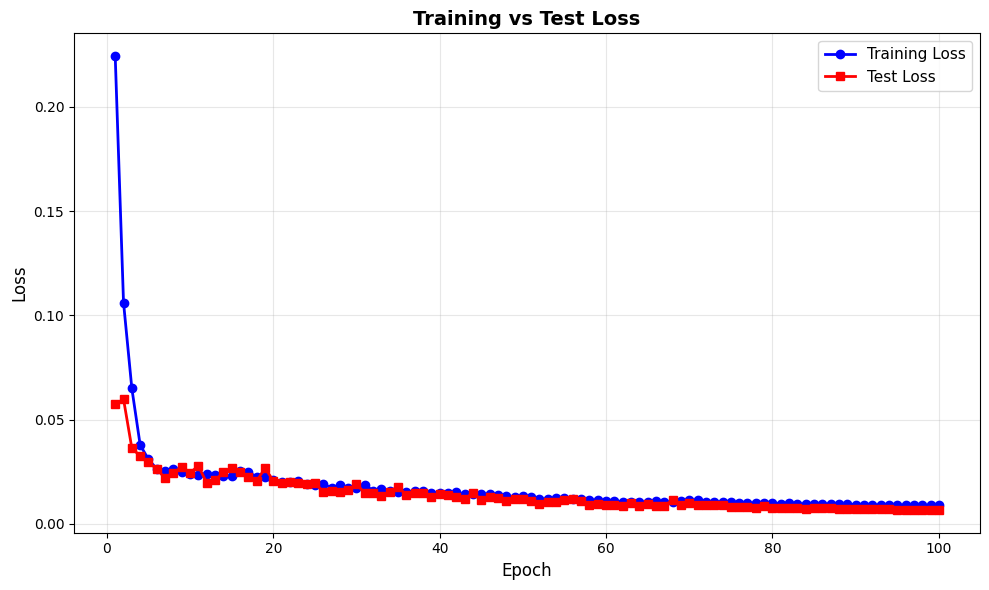

✅ Plot saved: /kaggle/working/DENSE_FUSION20251223_192627/training_loss.png


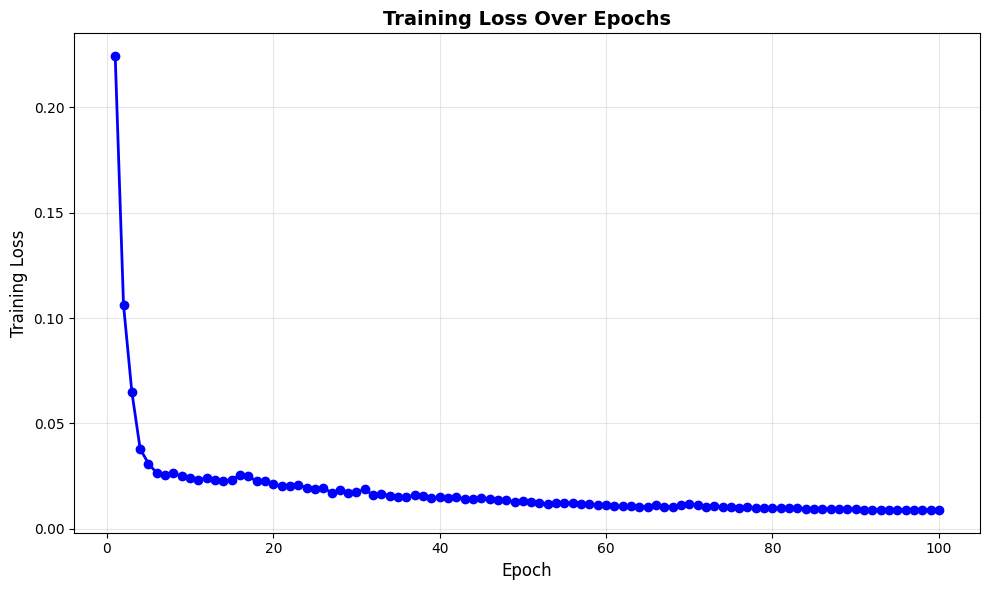

✅ Plot saved: /kaggle/working/DENSE_FUSION20251223_192627/test_loss.png


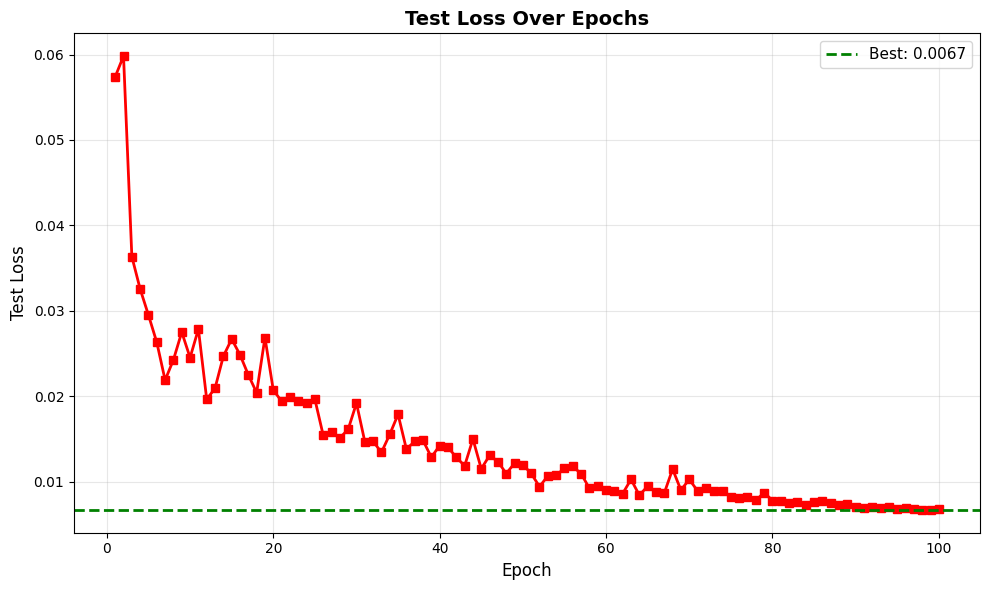


✅ All plots saved in '/kaggle/working/DENSE_FUSION20251223_192627' directory!


In [18]:
import matplotlib.pyplot as plt

# Create plots directory
# plots_dir = "plots"
plots_dir = checkpoint_dir
os.makedirs(plots_dir, exist_ok=True)

# Plot 1: Training vs Test Loss
plt.figure(figsize=(10, 6))
epochs_range = range(1, len(test_losses)+1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(range(1, len(test_losses)+1), test_losses, 'r-s', label='Test Loss', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Test Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
loss_plot_path = os.path.join(plots_dir, "loss_comparison.png")
plt.savefig(loss_plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {loss_plot_path}")
plt.show()

# Plot 2: Only Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
train_loss_path = os.path.join(plots_dir, "training_loss.png")
plt.savefig(train_loss_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {train_loss_path}")
plt.show()

# Plot 3: Only Test Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_losses)+1), test_losses, 'r-s', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.title('Test Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=best_test_loss, color='g', linestyle='--', label=f'Best: {best_test_loss:.4f}', linewidth=2)
plt.legend(fontsize=11)
plt.tight_layout()
test_loss_path = os.path.join(plots_dir, "test_loss.png")
plt.savefig(test_loss_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {test_loss_path}")
plt.show()

print(f"\n✅ All plots saved in '{plots_dir}' directory!")

In [20]:
# Save losses
import pickle


losses_dict = {
    'train_losses': train_losses,
    'test_losses': test_losses
}

losses_path = os.path.join(checkpoint_dir, "losses.pkl")
with open(losses_path, 'wb') as f:
    pickle.dump(losses_dict, f)


# Visualize samples

Loading FusionPoseModel from /kaggle/working/DENSE_FUSION20251223_192627/best_model.pth...


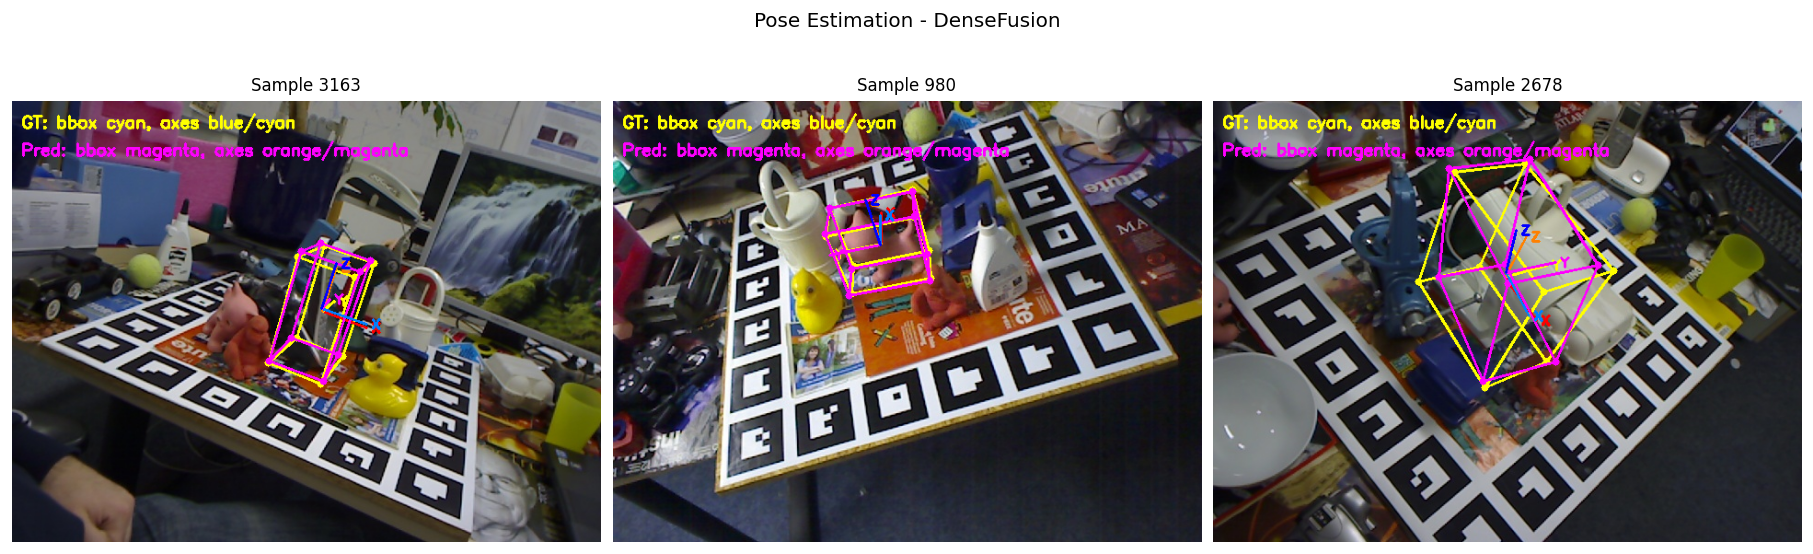

In [23]:
import importlib
import src.dense_fusion.visualize

# 1. Ricarica forzatamente il file modificato
importlib.reload(src.dense_fusion.visualize)

# 2. Ora importa la funzione aggiornata
from src.dense_fusion.visualize import visualize_densefusion_random_samples
import torch

dataset_root = "/kaggle/input/line-mode/Linemod_preprocessed"
checkpoint_path = "/kaggle/working/DENSE_FUSION20251223_192627"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


visualize_densefusion_random_samples(
    checkpoint_dir=checkpoint_path,
    dataset_root=dataset_root,
    device=device,
    num_samples=3
)


# Evaluation

In [2]:
import sys

sys.path.append("../..")

In [25]:
import importlib
import src.dense_fusion.evaluate

# 1. Ricarica forzatamente il file modificato
importlib.reload(src.dense_fusion.evaluate)

# 2. Ora importa la funzione aggiornata
from src.dense_fusion.evaluate import evaluate_DENSEFUSION

MODEL_PATH = "/kaggle/working/DENSE_FUSION20251223_192627/best_model.pth"            # Path to the trained model
DATASET_ROOT = "/kaggle/input/line-mode/Linemod_preprocessed"  # Path to the Linemod dataset
OUTPUT_PATH = "/kaggle/working/linemod_evaluation_report.csv"  # Path to save the evaluation report

evaluate_DENSEFUSION(
    model_path=MODEL_PATH,
    dataset_root=DATASET_ROOT,
    output_path=OUTPUT_PATH
)

📥 Loading 3D model points and diameters...
📦 Loading trained DenseFusion model from /kaggle/working/DENSE_FUSION20251223_192627/best_model.pth...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📚 Preparing test dataset and dataloader...

🚀 Starting Comprehensive Benchmark (ADD Error + ADD-0.1d Accuracy)...


Evaluating: 100%|██████████| 50/50 [02:53<00:00,  3.47s/batch]


📊 Evaluation report saved to /kaggle/working/linemod_evaluation_report.csv


,Object ID,Object Name,Diameter (mm),Mean ADD (mm),Mean ADD-S (mm),Mean ADD-Rot (mm),Mean ADD-S-Rot (mm),ADD-0.1d Accuracy (%),ADD-S-0.1d Accuracy (%)
0,1,ape,102.098657,3.436981,1.372506,3.437143,1.372603,97.177419,100.000000
1,2,benchvise,247.506242,5.959521,2.849069,5.959939,2.849279,100.000000,100.000000
2,4,camera,172.492249,4.303803,1.817831,4.303952,1.817926,99.170124,100.000000
3,5,can,201.403586,7.084185,2.528866,7.084407,2.529094,95.833333,99.583333
4,6,cat,154.545518,3.116810,1.513553,3.116896,1.513591,99.576271,100.000000
5,8,driller,261.471781,6.967637,3.406702,6.967801,3.406910,99.159664,100.000000
6,9,duck,108.999201,3.678265,1.501124,3.678398,1.501181,97.609562,100.000000
7,10,eggbox,164.627588,4.716771,1.818956,4.716773,1.818963,98.007968,100.000000
8,11,glue,175.889334,4.020399,2.030352,4.020644,2.030515,99.180328,100.000000
9,12,holepuncher,145.542875,3.332940,1.572649,3.332988,1.572666,99.596774,100.000000


In [4]:
import importlib
import src.dense_fusion.evaluate

# 1. Ricarica forzatamente il file modificato
importlib.reload(src.dense_fusion.evaluate)

# 2. Ora importa la funzione aggiornata
from src.dense_fusion.evaluate import evaluate_DENSEFUSION

# MODEL_PATH = "/kaggle/working/DENSE_FUSION20251223_192627/best_model.pth"            # Path to the trained model
# DATASET_ROOT = "/kaggle/input/line-mode/Linemod_preprocessed"  # Path to the Linemod dataset
# OUTPUT_PATH = "/kaggle/working/linemod_evaluation_report.csv"  # Path to save the evaluation report

MODEL_PATH = "./dense_final/best_model.pth"            # Path to the trained model
DATASET_ROOT = "../../Linemod_preprocessed"  # Path to the Linemod dataset
OUTPUT_PATH = "./dense_final/linemod_evaluation_report_full.csv"  # Path to save the evaluation report

yolo_path = "../../YOLO_outputs"

evaluate_DENSEFUSION(
    model_path=MODEL_PATH,
    dataset_root=DATASET_ROOT,
    output_path=OUTPUT_PATH,
    yolo_path=yolo_path
)

📥 Loading 3D model points and diameters...
📦 Loading trained DenseFusion model from ./dense_final/best_model.pth...


c:\Users\fcaro\.virtualenvs\mlVenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\fcaro\.virtualenvs\mlVenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\fcaro/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:06<00:00, 7.52MB/s]


📚 Preparing test dataset and dataloader...

🚀 Starting Comprehensive Benchmark (ADD Error + ADD-0.1d Accuracy)...


Evaluating: 100%|██████████| 50/50 [05:03<00:00,  6.08s/batch]


📊 Evaluation report saved to ./dense_final/linemod_evaluation_report_full.csv


,Object ID,Object Name,Diameter (mm),Mean ADD (mm),Mean ADD-S (mm),Mean ADD-Rot (mm),Mean ADD-S-Rot (mm),ADD-0.1d Accuracy (%),ADD-S-0.1d Accuracy (%)
0,1,ape,102.098657,3.743057,1.416003,3.743157,1.416056,96.774194,100.000000
1,2,benchvise,247.506242,6.541268,3.081018,6.541715,3.081218,99.176955,100.000000
2,4,camera,172.492249,4.491235,1.876938,4.491352,1.876992,99.585062,100.000000
3,5,can,201.403586,6.639583,2.440389,6.639803,2.440623,97.500000,100.000000
4,6,cat,154.545518,3.363755,1.613628,3.363848,1.613667,99.152542,100.000000
5,8,driller,261.471781,7.824364,3.713588,7.824437,3.713679,98.319328,99.579832
6,9,duck,108.999201,3.654897,1.495745,3.655031,1.495818,96.812749,100.000000
7,10,eggbox,164.627588,4.502105,1.765381,4.502106,1.765387,99.203187,100.000000
8,11,glue,175.889334,4.326394,2.117993,4.326667,2.118188,98.770492,100.000000
9,12,holepuncher,145.542875,3.797528,1.619733,3.797487,1.619777,99.193548,100.000000
